## Enunciado da Questão

Utilize a rede neural perceptron de múltiplas camadas do tipo NARX (rede MLP recorrente) para fazer a predição de um passo $\hat{u}(n+1)$ da série temporal:

$$u(n) = 0.5 \frac{\sin(\pi n)}{\pi n} + 0.1 \frac{\sin(n-1)\pi}{\pi(n-1)} - 0.05 \frac{\sin(n-2)\pi}{\pi(n-2)}$$
$$n=0, 1, 2, 3, \dots$$

Considerando as seguintes arquiteturas de entrada (regressores):

$$(i) \quad \hat{u}(n+1) = f(u(n))$$
$$(ii) \quad \hat{u}(n+1) = f(u(n), u(n-1))$$
$$(iii) \quad \hat{u}(n+1) = f(u(n), u(n-1), u(n-2), u(n-3), u(n-4), u(n-5))$$

Gere inicialmente um conjunto de amostras para o treinamento e um conjunto de amostras de teste. Avalie o desempenho mostrando a curva da série temporal ($u(n+1)$), a curva de predição ($\hat{u}(n+1)$) e a curva do erro de predição definido como $e(n+1) = u(n+1) - \hat{u}(n+1)$.

Faça uso no processo de treinamento da estratégia denominada **resposta forçada do professor** (*teacher forcing*), i.e., utilize como entrada os verdadeiros valores de $u(n)$ (os *targets*) e não utilize os laços de realimentação no treinamento que forneceriam os valores de $\hat{u}(n)$. Só utilize os valores da realimentação (os $\hat{u}(n)$ preditos) na validação ou teste.

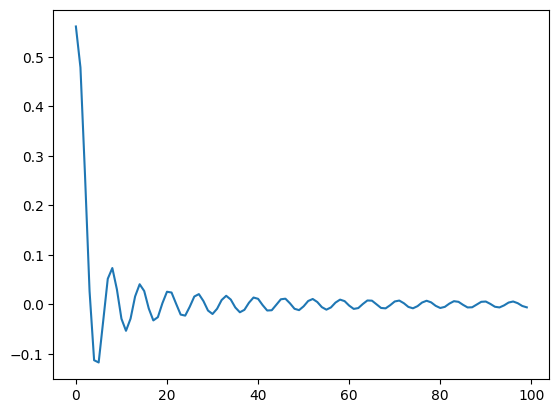

In [57]:
import numpy as np

def sinc_unnormalized(x):
    """
    Calcula sin(x)/x, tratando a singularidade em x=0 usando o limite (1).
    """
    if np.isclose(x, 0):
        return 1.0
    return np.sin(x) / x

def u_n(n: int) -> float:
    """
    Calcula o valor de u(n) para a série temporal.

    u(n) = 0.5 * sin(n)/n + 0.1 * sin(n-1)/(n-1) - 0.05 * sin(n-2)/(n-2)

    Note: Para n=0, n=1 e n=2, alguns termos têm singularidades.
    Usamos o limite sin(x)/x -> 1 quando x -> 0.
    """
    
    if n < 0:
        raise ValueError("n deve ser um inteiro não-negativo.")
    
    # Termo 1: 0.5 * sin(n)/n
    if n == 0:
        term1 = 0.5 * 1.0  # Limite de sin(n)/n quando n->0 é 1
    else:
        # A expressão na questão é: 0.5 * sin(n*pi)/(pi*n). 
        # Se for sin(n*pi)/(pi*n) que é a sinc normalizada:
        # if n == 0: 1.0, se n é inteiro não-zero: 0.
        # ASSUMINDO a sua expressão tal como está: 0.5 * sin(n)/n (o pi cancela)
        term1 = 0.5 * sinc_unnormalized(n) 

    # Termo 2: 0.1 * sin(n-1)/(n-1)
    n_minus_1 = n - 1
    if n_minus_1 == 0:
        term2 = 0.1 * 1.0  # Limite de sin(x)/x quando x->0 é 1
    else:
        term2 = 0.1 * sinc_unnormalized(n_minus_1)

    # Termo 3: -0.05 * sin(n-2)/(n-2)
    n_minus_2 = n - 2
    if n_minus_2 == 0:
        term3 = -0.05 * 1.0  # Limite de sin(x)/x quando x->0 é 1
    else:
        term3 = -0.05 * sinc_unnormalized(n_minus_2)
        
    return term1 + term2 + term3

# Para gerar uma série de valores:
N_AMOSTRAS = 100
N = range(0, N_AMOSTRAS)
series = [u_n(n) for n in N]

import matplotlib.pyplot as plt

plt.plot(N, series)
plt.show()

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim

# Função para criar dataset
def create_dataset(series, window_size):
    X, Y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        Y.append(series[i+window_size])
    X = np.array(X)
    Y = np.array(Y)
    return torch.tensor(X, dtype=torch.float32).unsqueeze(-1), torch.tensor(Y, dtype=torch.float32).unsqueeze(-1)

def split_train_test(X, Y, test_ratio=0.3):
    total = len(X)
    split_idx = int(total * (1 - test_ratio))
    X_train, X_test = X[:split_idx], X[split_idx:]
    Y_train, Y_test = Y[:split_idx], Y[split_idx:]
    return X_train, Y_train, X_test, Y_test


In [59]:
class RNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=16, num_layers=1):
        super(RNNPredictor, self).__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) #Última saída da sequência
        return out

In [60]:
# Função de treino
def treinar_modelo(model, X_train, y_train, epochs=500, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % int(epochs*0.1) == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.5f}")
    return model

# Função de avaliação
def avaliar_modelo(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        mse = nn.MSELoss()(preds, y_test).item()
    return preds.squeeze().numpy(), mse

In [61]:
# Testando os 3 casos propostos

window_sizes = [1, 2, 5]
predicoes = []

for w in window_sizes:
    print(f"\n=== Janela = {w} ===")
    X, Y = create_dataset(series, w)
    X_train, y_train, X_test, y_test = split_train_test(X, Y, test_ratio=0.3)

    model = RNNPredictor(input_size=1)
    model = treinar_modelo(model, X_train, y_train, epochs=100)

    # Avaliar
    y_pred, mse = avaliar_modelo(model, X_test, y_test)
    print(f"MSE no teste: {mse:.6f}")
    
    predicoes.append((w, X_test, y_test, y_pred))


=== Janela = 1 ===
Epoch 10/100 - Loss: 0.00237
Epoch 20/100 - Loss: 0.00160
Epoch 30/100 - Loss: 0.00134
Epoch 40/100 - Loss: 0.00126
Epoch 50/100 - Loss: 0.00113
Epoch 60/100 - Loss: 0.00110
Epoch 70/100 - Loss: 0.00110
Epoch 80/100 - Loss: 0.00110
Epoch 90/100 - Loss: 0.00110
Epoch 100/100 - Loss: 0.00110
MSE no teste: 0.000023

=== Janela = 2 ===
Epoch 10/100 - Loss: 0.00167
Epoch 20/100 - Loss: 0.00112
Epoch 30/100 - Loss: 0.00079
Epoch 40/100 - Loss: 0.00064
Epoch 50/100 - Loss: 0.00050
Epoch 60/100 - Loss: 0.00039
Epoch 70/100 - Loss: 0.00030
Epoch 80/100 - Loss: 0.00023
Epoch 90/100 - Loss: 0.00018
Epoch 100/100 - Loss: 0.00015
MSE no teste: 0.000009

=== Janela = 5 ===
Epoch 10/100 - Loss: 0.00430
Epoch 20/100 - Loss: 0.00157
Epoch 30/100 - Loss: 0.00057
Epoch 40/100 - Loss: 0.00026
Epoch 50/100 - Loss: 0.00017
Epoch 60/100 - Loss: 0.00012
Epoch 70/100 - Loss: 0.00006
Epoch 80/100 - Loss: 0.00003
Epoch 90/100 - Loss: 0.00001
Epoch 100/100 - Loss: 0.00001
MSE no teste: 0.00000

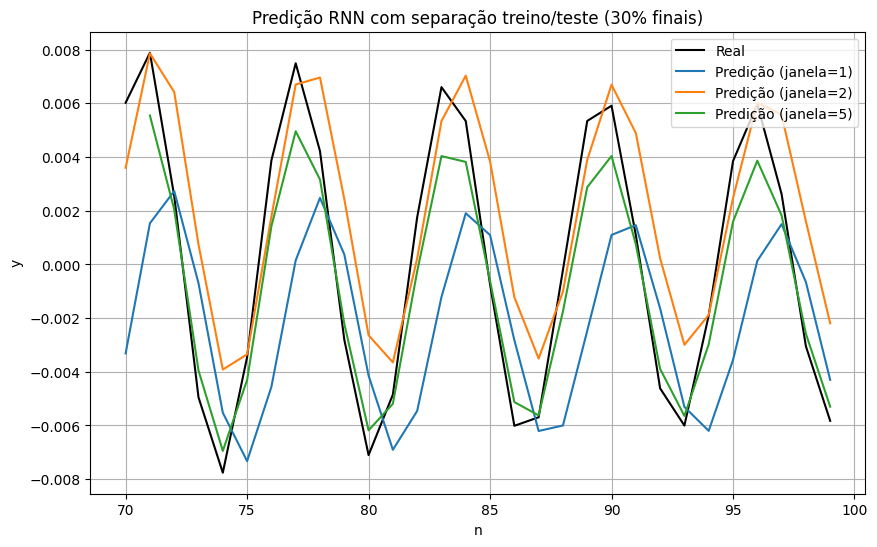

In [68]:
plt.figure(figsize=(10, 6))

# Descobre o tamanho do primeiro conjunto de teste (para plote real)
tam_teste = len(predicoes[0][2])
start_idx = N_AMOSTRAS - tam_teste

plt.plot(range(start_idx, N_AMOSTRAS), series[N_AMOSTRAS - tam_teste:], label="Real", color='black')

for w, X_test, y_test, y_pred in predicoes:
    tam_pred = len(y_pred)  # garante que o eixo x tem o mesmo tamanho do y_pred
    start_idx_local = N_AMOSTRAS - tam_pred
    plt.plot(range(start_idx_local, N_AMOSTRAS), y_pred, label=f"Predição (janela={w})")

plt.legend()
plt.title("Predição RNN com separação treino/teste (30% finais)")
plt.xlabel("n")
plt.ylabel("y")
plt.grid(True)
plt.show()
